In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import sys
from multiprocessing.pool import ThreadPool

In [2]:
# Optimal environment scaling parameters for lettuce
opt_min = tf.convert_to_tensor([
    70, 70, 70, 70, 0, 18, 18, 18, 18, 0, 60, 60, 60, 60, 0,
    101, 101, 101, 101, 0, 10, 10, 10, 10, 0,
], dtype=tf.float32)
opt_max = tf.convert_to_tensor([
    75, 75, 75, 75, 1, 21, 21, 21, 21, 1, 70, 70, 70, 70, 1,
    102, 102, 102, 102, 1, 15, 15, 15, 15, 1,
], dtype=tf.float32)

opt = tf.stack([opt_min, opt_max])
opt


def PE(pos, i, d_model):
    angle_rates = 1 / (10000 ** ((2 * i) / d_model))
    angle_rads = pos * angle_rates
    sines = tf.math.sin(angle_rads)
    cosines = tf.math.cos(angle_rads)
    return tf.where(tf.math.equal(i % 2, 0), sines, cosines)

def PositionalEncodings(num_timestamp, num_feature, skip=0):
    pos = tf.range(start=skip, limit=num_timestamp, delta=1, dtype=tf.float32)
    i = tf.range(num_feature, dtype=tf.float32)

    pos_encodings = PE(pos=tf.expand_dims(pos, -1), i=tf.expand_dims(i, 0), d_model=num_feature)
    return pos_encodings

# Series x shape (timestamp, feature)
def NormalizationSeries(x, epsilon=1e-6, gamma=1.0, beta=0.0):
    mean_x = tf.reduce_mean(x, axis=0)
    var_x = tf.reduce_mean((x - mean_x) ** 2, axis=0)
    normal_x = (x - mean_x) / (tf.sqrt(var_x) + epsilon)
    return normal_x * gamma + beta

def Preprocessing(x):
    s = x.numpy()
    opt_min = s[-2]
    opt_max = s[-1]
    s = s[:-2]
    return (s - opt_min) / (opt_max - opt_min)

# Series shape (timestamp, feature)
# opt (min, max)
def PreprocessingSeries(series, opt):
    s_o = tf.concat([series, opt], axis=0)
    series = tf.map_fn(fn=Preprocessing, elems=tf.transpose(s_o))
    return tf.transpose(series)

def da_s_si(x):
    one = tf.ones_like(x)
    x1 = tf.matmul(x, tf.transpose(one, perm=[0, 2, 1]))
    x2 = tf.eye(x1.shape[-1]) - tf.matmul(one, tf.transpose(x, perm=[0, 2, 1]))
    return x1 * x2

def da_s_s(a_s):
    a_s_x = tf.expand_dims(a_s, -1)
    return da_s_si(a_s_x)

def progressBar(count_value, total, suffix_1='epoch', suffix_2='loss'):
    bar_length = 20

    if count_value > total:
        count_value = total

    filled_up_Length = int(round(bar_length* count_value / float(total)))
    percentage = round(100.0 * count_value/float(total),1)

    bar = '=' * filled_up_Length + '-' * (bar_length - filled_up_Length)

    sys.stdout.write('%s [%s] %s%s -%s\t\r' %(suffix_1, bar, percentage, '%', suffix_2))
    sys.stdout.flush()

In [3]:
class SchedulerModel:
    def __init__(self, d_model, num_query, num_value, num_class):
        self.d_model = d_model
        self.num_query = num_query
        self.num_value = num_value
        self.num_class = num_class

        self.__build()
        self.set_optimization()

    def __build(self):
        self.wq = tf.random.normal(shape=(self.d_model, self.d_model), dtype=tf.float32, name="W_Q")
        self.wk = tf.random.normal(shape=(self.d_model, self.d_model), dtype=tf.float32, name="W_K")
        self.wv = tf.random.normal(shape=(self.d_model, self.d_model), dtype=tf.float32, name="W_V")
        self.wo = tf.random.normal(shape=(self.d_model, self.d_model), dtype=tf.float32, name="W_O")

        self.w2 = tf.random.normal(shape=(self.d_model, self.d_model*4), dtype=tf.float32, name="W_2")
        self.b2 = tf.zeros(shape=(self.num_query, self.d_model*4), name="b_2")

        self.w3 = tf.random.normal(shape=(self.d_model*4, self.d_model), dtype=tf.float32, name="W_3")
        self.b3 = tf.zeros(shape=(self.num_query, self.d_model), dtype=tf.float32, name="b_3")
        
        self.w4 = tf.random.normal(shape=(self.num_query*self.d_model, self.num_class), dtype=tf.float32, name="W_3")
        self.b4 = tf.zeros(shape=(self.num_class, 1), dtype=tf.float32, name="b_3")

    def get_weights(self):
        return {attr: getattr(self, attr) for attr in dir(self) if not attr.startswith("_") and not callable(getattr(self, attr))}

    def set_weights(self, weight_variables):
        for attr, weight_var in weight_variables.items():
            setattr(self, attr, weight_var)

    def save_weights(self, filename="model.weights"):
        with open(f"{filename}.pickle", "wb") as f:
            pickle.dump(obj=self.get_weights(), file=f, protocol=5)

    def load_weights(self, filename="model.weights"):
        with open(f"{filename}.pickle", "rb") as f:
            weight_variables = pickle.load(file=f)
            self.set_weights(weight_variables)

    def __forward(self, q, k, v, training=False):

        zq = q @ self.wq
        zk = k @ self.wk
        zv = v @ self.wv

        aq = tf.math.tanh(zq)
        ak = tf.math.tanh(zk)
        av = tf.math.tanh(zv)

        s = (aq @ tf.transpose(ak)) / (self.d_model**0.5)
        a_s = tf.math.softmax(s)

        z1 = a_s @ av @ self.wo
        a1 = NormalizationSeries(z1)
        zrq = a1 + q

        z2 = zrq @ self.w2 + self.b2
        a2 = tf.math.maximum(tf.zeros_like(z2), z2)

        z3 = (a2 @ self.w3 + self.b3)
        a3 = NormalizationSeries(z3)
        zrn = a3 + zrq

        zf = tf.reshape(zrn, (1, self.num_query*self.d_model))
        z4 = zf @ self.w4 + self.b4

        o = tf.math.sigmoid(z4)

        if not training:
            return o

        return o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, z4
    
    def __compute_loss_numerically_stable(self, y_true, z4):
        return -1 * (-y_true * tf.math.log(1 + tf.math.exp(-z4)) +
                 (1-y_true) * (-z4 - tf.math.log(1+tf.math.exp(-z4))))

    def __compute_accuracy_score(self, y_predict, y_true):
        if y_predict.shape != y_true.shape:
            raise ValueError("y_true and y_predict must have the same shape.")
        return tf.math.reduce_mean(1.0 - tf.math.abs(y_true-y_predict))
        

    def __back_propagation(self, q, k, v, o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, y):

        dl_b4 = o - y
        dl_w4 = tf.transpose(zf) @ dl_b4

        dl_b3 = tf.reshape(self.w4 @ tf.transpose(o - y), a3.shape) / a3
        dl_w3 = tf.transpose(a2) @ dl_b3

        dl_b2 = dl_b3 @ tf.transpose(self.w3)
        dl_w2 = tf.transpose(zrq) @ dl_b2
        
        dl_z1 = (dl_b2 @ tf.transpose(self.w2)) / a1
        dl_wo = tf.transpose(a_s @ av) @ dl_z1

        da_s_s_avg = tf.math.reduce_mean(da_s_s(a_s), axis=0)
        dl_wq = tf.transpose(dl_z1) @ ((tf.ones_like(aq) @ tf.transpose(ak)) / (self.d_model**0.5)) @ da_s_s_avg @ av @ self.wo @ tf.transpose(q) @ (1 - (aq ** 2))
        dl_wk = tf.transpose(dl_z1) @ ((aq @ tf.ones_like(tf.transpose(ak))) / (self.d_model**0.5)) @ da_s_s_avg @ av @ self.wo @ tf.transpose(k) @ (1 - (ak ** 2))
        dl_wv = tf.transpose(dl_z1) @ a_s @ tf.ones_like(av) @ self.wo @ tf.transpose(v) @ (1 - (av ** 2))

        return dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4
    
    def set_optimization(self, learning_rate=1e-4, epsilon=1e-9, beta1=0.9, beta2=0.98):
        self.__learning_rate = learning_rate
        self.__epsilon = epsilon
        self.__beta1 = beta1
        self.__beta2 = beta2

    def __adam(self, gt, t, mt, st):
        mt = (self.__beta1 * mt) + ((1 - self.__beta1) * gt)
        st = (self.__beta2 * st) + ((1 - self.__beta2) * (gt ** 2))

        mc = mt / (1 - (self.__beta1 ** t))
        sc = st / (1 - (self.__beta2 ** t))

        return -self.__learning_rate * (mc / ((sc ** 0.5) + self.__epsilon)), mt, st
    
    def __time_encoding(self, v):
        num_value = v.shape[0]
        k = v + PositionalEncodings(num_timestamp=num_value, num_feature=self.d_model)
        q = PositionalEncodings(num_timestamp=num_value+self.num_query, num_feature=self.d_model, skip=self.num_value)
        return q, k
    
    
    def __train_step(self, x_steps, y_steps):

        out = []

        v = x_steps[0]
        q, k = self.__time_encoding(v)
        y = y_steps[0]

        o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, z4 = self.__forward(q, k, v, training=True)
        l = self.__compute_loss_numerically_stable(y, z4)
        out.append(o)

        dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4 = self.__back_propagation(
                q, k, v, o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, y,
        )

        num_steps = len(x_steps)

        for s in range(1, num_steps):
            v = x_steps[s]
            q, k = self.__time_encoding(v)
            y = y_steps[s]

            o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, z4 = self.__forward(q, k, v, training=True)
            l = l + self.__compute_loss_numerically_stable(y, z4)
            out.append(o)

            dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4 = (
                a + b for a, b in zip(
                    (dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4),
                    self.__back_propagation(q, k, v, o, aq, ak, av, a_s, a1, zrq, a2, a3, zf, y),
                )
            )

        dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4 = (
            x / num_steps for x in (dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4)
        )

        l = l / num_steps

        accuracy = tuple(self.__compute_accuracy_score(o, y) for o, y in zip(out, y_steps))
        accuracy = tf.math.reduce_mean(tf.convert_to_tensor(accuracy))

        return l, accuracy, dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4


    def train(self, x_train, y_train, batch_size=32, x_test=None, y_test=None, epochs=None, learning_rate=None, warmup_steps=1000, save_best=True, stop_epochs=50):
        self.__learning_rate = learning_rate

        num_samples = len(x_train)
        if num_samples < batch_size:
            batch_size = num_samples

        if num_samples != len(y_train):
            raise ValueError(f"Error: len(x_train) != len(y_train)")
        for i in range(num_samples):
            if x_train[i].shape[-1] != self.d_model:
                raise ValueError("Error: x_train[i].shape[-1] != self.d_model")
            if y_train[i].shape[-1] != self.num_class:
                raise ValueError("Error: y_train[i].shape[-1] != self.num_class")
            
        if x_test is not None:
            if len(x_test) != len(y_test):
                raise ValueError(f"Error: len(x_test) != len(y_test)")
            for i in range(len(x_test)):
                if x_test[i].shape[-1] != self.d_model:
                    raise ValueError("Error: x_test[i].shape[-1] != self.d_model")
                if y_test[i].shape[-1] != self.num_class:
                    raise ValueError("Error: y_test[i].shape[-1] != self.num_class")

        m_wq, m_wk, m_wv, m_wo, m_w2, m_b2, m_w3, m_b3, m_w4, m_b4 = tf.zeros(10)
        s_wq, s_wk, s_wv, s_wo, s_w2, s_b2, s_w3, s_b3, s_w4, s_b4 = tf.zeros(10)

        training_accuracy = []
        training_loss = []
        epochs_loss = []
        epochs_accuracy = []

        t = 0
        step = 0

        max_accuracy = 0.0
        running = stop_epochs

        while True:
            t += 1
            epochs_loss.clear()
            epochs_accuracy.clear()

            with ThreadPool(processes=1) as pool:

                results = [
                    pool.apply_async(func=self.__train_step, args=(x_train[i:i+batch_size], y_train[i:i+batch_size])) if i+batch_size <= num_samples 
                    else pool.apply_async(func=self.__train_step, args=(x_train[i:], y_train[i:])) for i in range(0, num_samples, batch_size)
                ]
                
                progress = 0

                for result in results:

                    l, accuracy, dl_wq, dl_wk, dl_wv, dl_wo, dl_w2, dl_b2, dl_w3, dl_b3, dl_w4, dl_b4 = result.get()
                    epochs_loss.append(l[0][0])
                    epochs_accuracy.append(accuracy)

                    step += 1
                    if learning_rate is None:
                        self.__learning_rate = (self.d_model ** -0.5) * tf.math.reduce_min(tf.constant([step ** -0.5, step * (warmup_steps ** -1.5)], dtype=tf.float32))
                    
                    d_wq, m_wq, s_wq = self.__adam(dl_wq, t, m_wq, s_wq)
                    m_wq = tf.where(tf.math.is_nan(m_wq), tf.zeros_like(m_wq), m_wq)
                    s_wq = tf.where(tf.math.is_nan(s_wq), tf.zeros_like(s_wq), s_wq)
                    d_wq = tf.where(tf.math.is_nan(d_wq), tf.zeros_like(d_wq), d_wq)

                    d_wk, m_wk, s_wk = self.__adam(dl_wk, t, m_wk, s_wk)
                    m_wk = tf.where(tf.math.is_nan(m_wk), tf.zeros_like(m_wk), m_wk)
                    s_wk = tf.where(tf.math.is_nan(s_wk), tf.zeros_like(s_wk), s_wk)
                    d_wk = tf.where(tf.math.is_nan(d_wk), tf.zeros_like(d_wk), d_wk)

                    d_wv, m_wv, s_wv = self.__adam(dl_wv, t, m_wv, s_wv)
                    m_wv = tf.where(tf.math.is_nan(m_wv), tf.zeros_like(m_wv), m_wv)
                    s_wv = tf.where(tf.math.is_nan(s_wv), tf.zeros_like(s_wv), s_wv)
                    d_wv = tf.where(tf.math.is_nan(d_wv), tf.zeros_like(d_wv), d_wv)

                    d_wo, m_wo, s_wo = self.__adam(dl_wo, t, m_wo, s_wo)
                    m_wo = tf.where(tf.math.is_nan(m_wo), tf.zeros_like(m_wo), m_wo)
                    s_wo = tf.where(tf.math.is_nan(s_wo), tf.zeros_like(s_wo), s_wo)
                    d_wo = tf.where(tf.math.is_nan(d_wo), tf.zeros_like(d_wo), d_wo)

                    d_w2, m_w2, s_w2 = self.__adam(dl_w2, t, m_w2, s_w2)
                    m_w2 = tf.where(tf.math.is_nan(m_w2), tf.zeros_like(m_w2), m_w2)
                    s_w2 = tf.where(tf.math.is_nan(s_w2), tf.zeros_like(s_w2), s_w2)
                    d_w2 = tf.where(tf.math.is_nan(d_w2), tf.zeros_like(d_w2), d_w2)

                    d_b2, m_b2, s_b2 = self.__adam(dl_b2, t, m_b2, s_b2)
                    m_b2 = tf.where(tf.math.is_nan(m_b2), tf.zeros_like(m_b2), m_b2)
                    s_b2 = tf.where(tf.math.is_nan(s_b2), tf.zeros_like(s_b2), s_b2)
                    d_b2 = tf.where(tf.math.is_nan(d_b2), tf.zeros_like(d_b2), d_b2)

                    d_w3, m_w3, s_w3 = self.__adam(dl_w3, t, m_w3, s_w3)
                    m_w3 = tf.where(tf.math.is_nan(m_w3), tf.zeros_like(m_w3), m_w3)
                    s_w3 = tf.where(tf.math.is_nan(s_w3), tf.zeros_like(s_w3), s_w3)
                    d_w3 = tf.where(tf.math.is_nan(d_w3), tf.zeros_like(d_w3), d_w3)

                    d_b3, m_b3, s_b3 = self.__adam(dl_b3, t, m_b3, s_b3)
                    m_b3 = tf.where(tf.math.is_nan(m_b3), tf.zeros_like(m_b3), m_b3)
                    s_b3 = tf.where(tf.math.is_nan(s_b3), tf.zeros_like(s_b3), s_b3)
                    d_b3 = tf.where(tf.math.is_nan(d_b3), tf.zeros_like(d_b3), d_b3)

                    d_w4, m_w4, s_w4 = self.__adam(dl_w4, t, m_w4, s_w4)
                    m_w4 = tf.where(tf.math.is_nan(m_w4), tf.zeros_like(m_w4), m_w4)
                    s_w4 = tf.where(tf.math.is_nan(s_w4), tf.zeros_like(s_w4), s_w4)
                    d_w4 = tf.where(tf.math.is_nan(d_w4), tf.zeros_like(d_w4), d_w4)

                    d_b4, m_b4, s_b4 = self.__adam(dl_b4, t, m_b4, s_b4)
                    m_b4 = tf.where(tf.math.is_nan(m_b4), tf.zeros_like(m_b4), m_b4)
                    s_b4 = tf.where(tf.math.is_nan(s_b4), tf.zeros_like(s_b4), s_b4)
                    d_b4 = tf.where(tf.math.is_nan(d_b4), tf.zeros_like(d_b4), d_b4)


                    self.wq = self.wq + d_wq
                    self.wk = self.wk + d_wk
                    self.wv = self.wv + d_wv
                    self.wo = self.wo + d_wo

                    self.w2 = self.w2 + d_w2
                    self.b2 = self.b2 + d_b2

                    self.w3 = self.w3 + d_w3
                    self.b3 = self.b3 + d_b3

                    self.w4 = self.w4 + d_w4
                    self.b4 = self.b4 + d_b4

                    progress += 1

                    prefix_1 = f"epoch {t} "
                    prefix_2 = f"loss: {epochs_loss[-1]} - accuracy: {epochs_accuracy[-1]}  -- learning_rate: {self.__learning_rate}"
                    progressBar(progress*batch_size, num_samples, prefix_1, prefix_2)
            
            mean_loss = tf.math.reduce_mean(tf.convert_to_tensor(epochs_loss))
            training_loss.append(mean_loss)

            mean_accuracy = tf.math.reduce_mean(tf.convert_to_tensor(epochs_accuracy))
            training_accuracy.append(mean_accuracy)

            if save_best:
                if x_test is not None:
                    accuracy = self.evaluate(x_test, y_test)
                else:
                    accuracy = self.evaluate(x_train, y_train)

                if accuracy > max_accuracy:
                    self.save_weights("best.weights")
                    max_accuracy = accuracy
                    running = stop_epochs
                else:
                    running -= 1
                print(f"\nTest accuracy {accuracy}, Best accuracy {max_accuracy}\n")

            if t == epochs or running == 0:
                break

                
        return tf.convert_to_tensor(training_loss), tf.convert_to_tensor(training_accuracy)
    

    def __predict_step(self, v):
        q, k = self.__time_encoding(v)
        return self.__forward(q, k, v)
    
    def predict(self, inputs):
        return tuple(map(self.__predict_step, inputs))
    
    def evaluate(self, x_test, y_test):
        y_pre = self.predict(x_test)
        accuracy = tuple(self.__compute_accuracy_score(o, y) for o, y in zip(y_pre, y_test))
        accuracy = tf.math.reduce_mean(tf.convert_to_tensor(accuracy))
        return accuracy


In [4]:
dataset = pd.read_excel("./Data/lettuce_auto_scheduler_irrigation.xlsx")
dataset

,timestamps,soil_moisture_min (%),soil_moisture_mean (%),soil_moisture_max (%),soil_moisture_median (%),soil_moisture_standard_deviation (%),air_temperature_min (°C),air_temperature_mean (°C),air_temperature_max (°C),air_temperature_median (°C),...,air_pressure_mean (kPa),air_pressure_max (kPa),air_pressure_median (kPa),air_pressure_standard_deviation (kPa),luminosity_min (x1000 lux),luminosity_mean (x1000 lux),luminosity_max (x1000 lux),luminosity_median (x1000 lux),luminosity_standard_deviation (x1000 lux),Label_for_lettuce (Water pump state)
0,1.680503e+09,75.461830,79.245033,82.747971,79.242882,3.409924,29.75,31.386333,33.110001,31.515001,...,101.842087,101.891273,101.843781,0.032868,17.6742,20.266289,23.776199,20.169899,1.782542,0
1,1.680503e+09,75.461830,79.245033,82.747971,79.242882,3.409924,29.93,31.437664,33.110001,31.585001,...,101.840363,101.891273,101.841904,0.033184,17.6742,20.295061,23.776199,20.226601,1.766036,0
2,1.680504e+09,75.461830,79.259865,82.747971,79.242882,3.395334,30.09,31.484167,33.110001,31.620001,...,101.838493,101.891273,101.839691,0.033424,17.6742,20.221830,23.776199,20.069099,1.718155,0
3,1.680504e+09,75.461830,79.259865,82.747971,79.242882,3.395334,30.09,31.531500,33.110001,31.640001,...,101.836639,101.891273,101.837570,0.033693,17.6742,20.191952,23.776199,19.999800,1.723189,0
4,1.680504e+09,75.461830,79.274704,82.747971,79.242882,3.380615,30.09,31.586500,33.500000,31.650002,...,101.834839,101.889435,101.835403,0.033615,17.6742,20.181871,23.776199,19.949400,1.725977,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85268,1.702016e+09,51.074085,56.278072,61.605164,56.222878,5.154098,11.65,12.325000,13.400000,12.240000,...,102.711784,102.729858,102.715378,0.012820,0.0000,0.000000,0.000000,0.000000,0.000000,1
85269,1.702017e+09,51.074085,56.275307,61.605164,56.222878,5.151370,11.65,12.328167,13.400000,12.240000,...,102.711075,102.729858,102.714783,0.013356,0.0000,0.000000,0.000000,0.000000,0.000000,1
85270,1.702017e+09,51.074085,56.275307,61.605164,56.222878,5.151370,11.65,12.331000,13.400000,12.240000,...,102.710373,102.729858,102.714401,0.013616,0.0000,0.000000,0.000000,0.000000,0.000000,1
85271,1.702017e+09,51.074085,56.272537,61.605164,56.222878,5.148638,11.65,12.331334,13.400000,12.240000,...,102.709610,102.729858,102.714073,0.014087,0.0000,0.000000,0.000000,0.000000,0.000000,1


In [5]:
data = dataset[dataset.columns[1:-1]].to_numpy().astype(np.float32)
data = PreprocessingSeries(data, opt).numpy()
data.shape

(85273, 25)

In [6]:
label = dataset[dataset.columns[-1]].to_numpy().astype(np.float32)
label.shape

(85273,)

In [7]:
d_model = data.shape[-1] # number of timestamp feature
num_query = 30 # 30 timestamps = 2 coming hours
num_value = 150 # 150 timestamps = 10 previous hours
num_class = 1 # Pump On (1) or Off (0)

In [8]:
x_idx = np.expand_dims(np.arange(data.shape[0]-num_query-num_value+1), axis=-1) + np.expand_dims(np.arange(num_value), axis=0)
x_idx

array([[    0,     1,     2, ...,   147,   148,   149],
       [    1,     2,     3, ...,   148,   149,   150],
       [    2,     3,     4, ...,   149,   150,   151],
       ...,
       [85091, 85092, 85093, ..., 85238, 85239, 85240],
       [85092, 85093, 85094, ..., 85239, 85240, 85241],
       [85093, 85094, 85095, ..., 85240, 85241, 85242]])

In [9]:
y_idx = np.arange(num_value+num_query-1, data.shape[0], 1)
y_idx

array([  179,   180,   181, ..., 85270, 85271, 85272])

In [10]:
x = data[x_idx]
x.shape

(85094, 150, 25)

In [11]:
y = np.expand_dims(np.expand_dims(label[y_idx], axis=-1), axis=-1)
y.shape

(85094, 1, 1)

In [12]:
m1 = np.where(y == 1)[0].shape[0]
m1

37247

In [13]:
m2 = np.where(y == 0)[0].shape[0]
m2

47847

In [14]:
test_idx = np.concatenate((np.random.choice(np.where(y == 1)[0], size=m1//5, replace=False), np.random.choice(np.where(y == 0)[0], size=m2//5, replace=False)))
test_idx.shape

(17018,)

In [15]:
x_test = x[test_idx]
y_test = y[test_idx]

In [16]:
x_train = np.delete(x, test_idx, axis=0)
y_train = np.delete(y, test_idx, axis=0)

In [17]:
(x_train.shape[0]+x_test.shape[0]-x.shape[0]) == 0

True

In [18]:
del dataset, data, x, y, x_idx, y_idx, test_idx, m1, m2

In [19]:
x_test.shape, y_test.shape, x_train.shape, y_train.shape

((17018, 150, 25), (17018, 1, 1), (68076, 150, 25), (68076, 1, 1))

In [20]:
model = SchedulerModel(d_model, num_query, num_value, num_class)

In [21]:
loss, acc = model.train(
    x_train, y_train, epochs=2000, batch_size=360,
    x_test=x_test, y_test=y_test, warmup_steps=4000, save_best=True,
)

epoch 1  [====================] 100.0% -loss: 0.0 - accuracy: 1.0  -- learning_rate: 0.0001502081868238747	rate: 0.00014941762492526323			
Test accuracy 0.51792973279953, Best accuracy 0.51792973279953

epoch 2  [====================] 100.0% -loss: 0.0 - accuracy: 1.0  -- learning_rate: 0.0003004163736477494	g_rate: 0.0002996257971972227	493	
Test accuracy 0.5339389443397522, Best accuracy 0.5339389443397522

epoch 3  [====================] 100.0% -loss: 0.0 - accuracy: 1.0  -- learning_rate: 0.0004506245895754546	rate: 0.0004498340131249279			5	
Test accuracy 0.5570712685585022, Best accuracy 0.5570712685585022

epoch 4  [====================] 100.0% -loss: 0.0 - accuracy: 1.0  -- learning_rate: 0.0006008327472954988	_rate: 0.000600042229052633				
Test accuracy 0.5813296437263489, Best accuracy 0.5813296437263489

epoch 5  [====================] 100.0% -loss: 0.0 - accuracy: 1.0  -- learning_rate: 0.0007510409341193736	_rate: 0.0007502503576688468		
Test accuracy 0.5985264778137207, 

In [21]:
import matplotlib.pyplot as plt

In [37]:
max_value = tf.reduce_max(loss)
loss = tf.where(tf.math.is_nan(loss), tf.fill(loss.shape, max_value), loss)

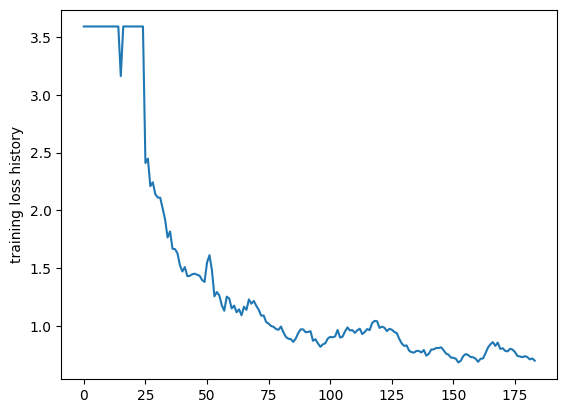

In [39]:
plt.plot(loss)
plt.ylabel('training loss history')
plt.show()

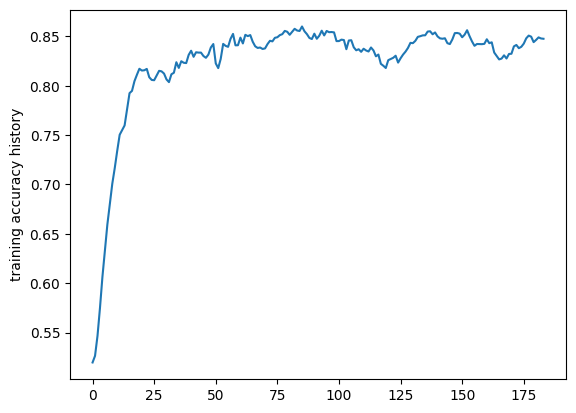

In [40]:
plt.plot(acc)
plt.ylabel('training accuracy history')
plt.show()

In [22]:
#model.load_weights("best.weights")
model.load_weights("best_09092024.weights")

In [24]:
model.evaluate(x_test, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.73227483>

In [74]:
test_idx = np.concatenate((
    np.random.choice(np.where(y_test == 1)[0], size=50, replace=False),
    np.random.choice(np.where(y_test == 0)[0], size=150, replace=False),
    np.random.choice(np.where(y_test == 1)[0], size=50, replace=False),
    np.random.choice(np.where(y_test == 0)[0], size=50, replace=False),
))
test_idx.shape

(300,)

In [75]:
x_test_1 = x_test[test_idx]
y_test_1 = y_test[test_idx]

In [76]:
y_pre = model.predict(x_test_1)
y_pre = tf.squeeze(y_pre)
y_test_1 = y_test_1.flatten()

In [77]:
def FilterPadding(tensor, filter_size):
    padding_size = filter_size - (tensor.shape[0] % filter_size)
    if padding_size != filter_size:
        return tf.concat((tensor, tf.ones(padding_size) * tensor[-1]), axis=0), padding_size
    return tensor, 0


def ProdFilter(tensor, filter_size, padding_size):
    tensor = tf.cast(tensor > 0.5, tf.float32)
    tensor = tf.reshape(tensor, (tensor.shape[0] // filter_size, filter_size))

    y_prod = tf.expand_dims(tf.reduce_prod(tensor, axis=-1), axis=-1) * tf.expand_dims(tf.ones(filter_size), axis=0)
    y_prod = tf.reshape(y_prod, (y_prod.shape[0] * y_prod.shape[-1],))
    if padding_size > 0:
        return tf.cast(y_prod[:-padding_size] > 0.5, tf.float32)
    return tf.cast(y_prod > 0.5, tf.float32)


def MeanFilter(tensor, filter_size, padding_size):
    tensor = tf.reshape(tensor, (tensor.shape[0] // filter_size, filter_size))
    y_mean = tf.expand_dims(tf.reduce_max(tensor, axis=-1), axis=-1) * tf.expand_dims(tf.ones(filter_size), axis=0)
    y_mean = tf.reshape(y_mean, (y_mean.shape[0] * y_mean.shape[-1],))
    if padding_size > 0:
        return tf.cast(y_mean[:-padding_size] >= 0.5, tf.float32)
    return tf.cast(y_mean >= 0.5, tf.float32)


def OutputFilter(y_predict, filter_size=5):
    y_predict = tf.squeeze(y_predict)

    y_predict_pad, pad_size = FilterPadding(y_predict, filter_size)
    y_prod = ProdFilter(y_predict_pad, filter_size, pad_size)

    y_predict_pad, pad_size = FilterPadding(y_prod, 2*filter_size)
    return MeanFilter(y_predict_pad, 2*filter_size, pad_size)


y_pre_f = OutputFilter(y_pre)

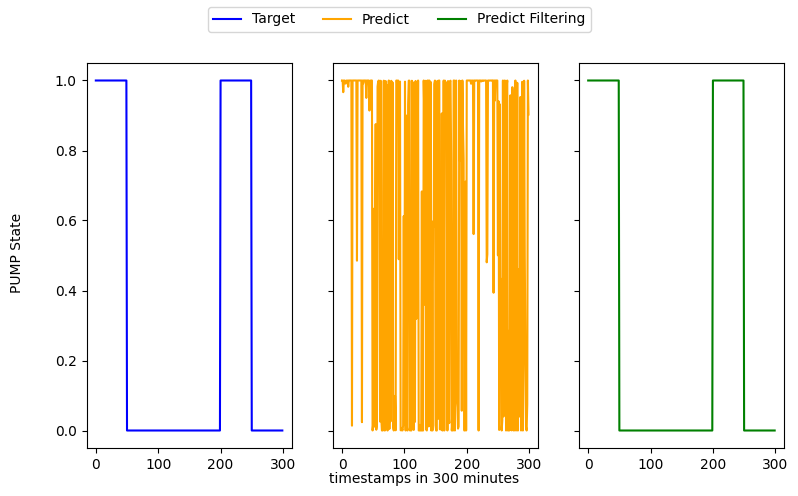

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 5))

ax3.plot(y_pre_f, label="Predict Filtering", color='green')
ax2.plot(y_pre, label="Predict", color='orange')
ax1.plot(y_test_1, label="Target", color='blue')

fig.text(0.5, 0.04, 'timestamps in 300 minutes', ha='center')
fig.text(0.04, 0.5, 'PUMP State', va='center', rotation='vertical')
fig.legend(loc='upper center', ncol=3)

plt.show()

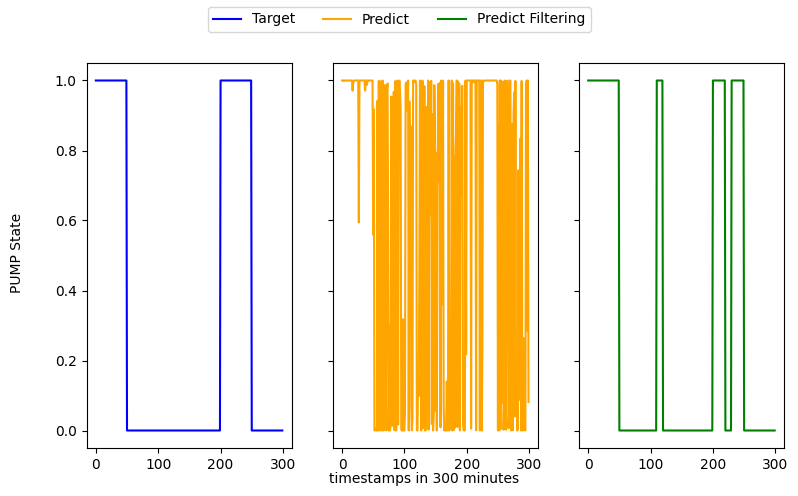

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 5))

ax3.plot(y_pre_f, label="Predict Filtering", color='green')
ax2.plot(y_pre, label="Predict", color='orange')
ax1.plot(y_test_1, label="Target", color='blue')

fig.text(0.5, 0.04, 'timestamps in 300 minutes', ha='center')
fig.text(0.04, 0.5, 'PUMP State', va='center', rotation='vertical')
fig.legend(loc='upper center', ncol=3)

plt.show()